### 1 вопрос: duration
### 2 вопрос: 0.89
### 3 вопрос: 0.265
### 4 вопрос: 0.22
### 5 вопрос: 0.006
### 6 вопрос: 1

In [1]:
import pandas as pd

data = pd.read_csv('bank-full.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
data = data[columns]

# Преобразуем категориальные признаки
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Разделение данных на обучение, валидацию и тест
train_data, test_data = train_test_split(data, test_size=0.4, random_state=1) # 60%
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=1) #20% и 20%

# Разделение на признаки и целевую переменную
X_train, y_train = train_data.drop(columns='y'), train_data['y']
X_val, y_val = val_data.drop(columns='y'), val_data['y']
X_test, y_test = test_data.drop(columns='y'), test_data['y']

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

# Важность признаков
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Важность признаков:")
print(feature_importances)

Важность признаков:
      Feature  Importance
9    duration    0.292487
4     balance    0.110842
0         age    0.106120
7         day    0.092015
8       month    0.088867
1         job    0.050728
11      pdays    0.049481
13   poutcome    0.049281
10   campaign    0.040784
3   education    0.029153
5     housing    0.024675
2     marital    0.023351
6     contact    0.021701
12   previous    0.020515


### 1 вопрос

In [4]:
from sklearn.metrics import roc_auc_score

numeric_features = ['age', 'balance', 'day', 'duration',
                    'campaign', 'pdays', 'previous']

auc_scores = {}

# Для каждой переменной вычисляем AUC
for feature in numeric_features:
    # Рассчитываем AUC с оригинальными значениями
    auc = roc_auc_score(y_train, X_train[feature])
    
    # Если AUC < 0.5, инвертируем значения
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feature])
    
    # Сохраняем результат
    auc_scores[feature] = auc

# Определение переменной с наибольшим значением AUC
max_auc_feature = max(auc_scores, key=auc_scores.get)
max_auc_score = auc_scores[max_auc_feature]

print("AUC для каждой числовой переменной:", auc_scores)
print("Переменная с наивысшим AUC:", max_auc_feature, "со значением AUC:", max_auc_score)

AUC для каждой числовой переменной: {'age': np.float64(0.5125105881599707), 'balance': np.float64(0.5916931412945473), 'day': np.float64(0.5291275984648961), 'duration': np.float64(0.8128648066681694), 'campaign': np.float64(0.5742447701740003), 'pdays': np.float64(0.5897967289320412), 'previous': np.float64(0.5986704105715122)}
Переменная с наивысшим AUC: duration со значением AUC: 0.8128648066681694


### 2 вопрос

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train_encoded, y_train)

# Предсказания на валидационном наборе и расчет AUC
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)

print(f"AUC на валидационном наборе: {auc:.3f}")

AUC на валидационном наборе: 0.865


### 3 вопрос

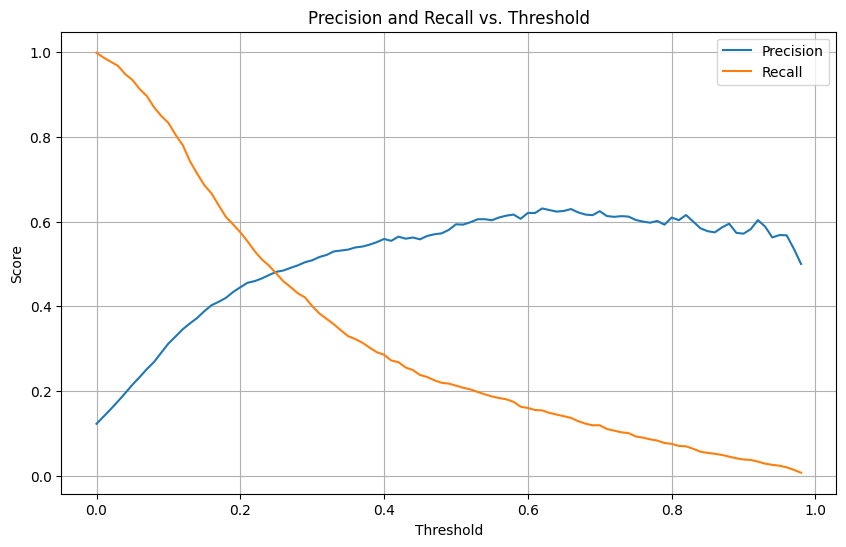

Порог, на котором precision и recall пересекаются: 0.250


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Вычисляем вероятности положительного класса
y_val_prob = model.predict_proba(X_val_encoded)[:, 1]

# Списки для хранения значений precision и recall
precision_scores = []
recall_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

# Расчёт precision и recall для каждого порога
for threshold in thresholds:
    y_val_pred = (y_val_prob >= threshold).astype(int)
    
    # Проверяем, предсказаны ли оба класса (0 и 1)
    if len(np.unique(y_val_pred)) < 2:
        continue  # Пропускаем пороги, при которых модель предсказывает только один класс
    
    # Вычисляем precision и recall с параметром zero_division=0
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

# Построение графиков precision и recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds[:len(precision_scores)], precision_scores, label='Precision')
plt.plot(thresholds[:len(recall_scores)], recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

# Поиск порога, на котором precision и recall пересекаются
precision_recall_diff = np.abs(np.array(precision_scores) - np.array(recall_scores))
intersection_index = np.argmin(precision_recall_diff)
intersection_threshold = thresholds[intersection_index]

print(f"Порог, на котором precision и recall пересекаются: {intersection_threshold:.3f}")

### 4 вопрос

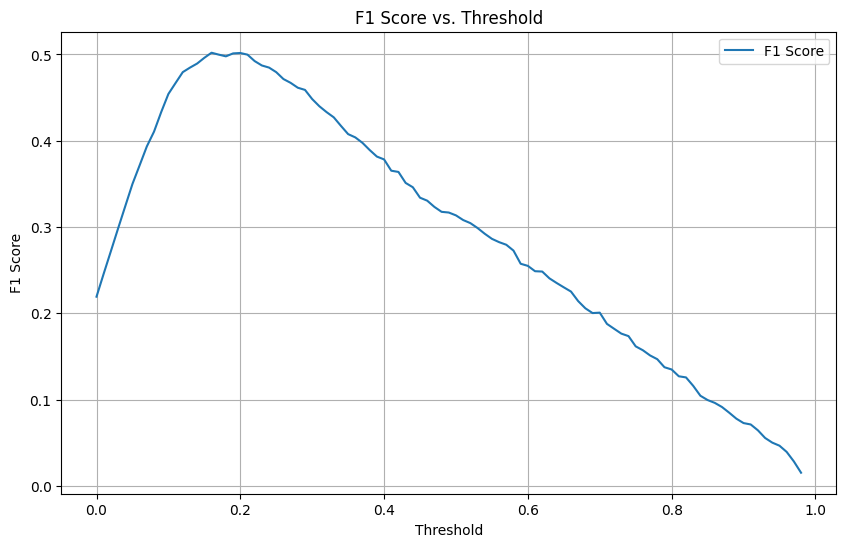

Порог, на котором F1 достигает максимума: 0.16


In [7]:
from sklearn.metrics import f1_score

f1_scores = []

# Вычисляем F1 для каждого порога от 0.0 до 1.0 с шагом 0.01
for threshold in thresholds:
    y_val_pred = (y_val_prob >= threshold).astype(int)
    
    # Проверяем, предсказаны ли оба класса (0 и 1)
    if len(np.unique(y_val_pred)) < 2:
        continue  # Пропускаем пороги, при которых модель предсказывает только один класс
    
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds[:len(f1_scores)], f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid()
plt.show()

max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]

print(f"Порог, на котором F1 достигает максимума: {max_f1_threshold:.2f}")

### 5 вопрос

In [8]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df_full_train = data
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

# Проход по фолдам
for train_idx, val_idx in kf.split(df_full_train):
    # Разделение данных на обучающую и валидационную выборки
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # Разделение на признаки и целевую переменную
    X_train = df_train.drop(columns='y')
    y_train = df_train['y']
    X_val = df_val.drop(columns='y')
    y_val = df_val['y']
    
    # Кодирование признаков
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Предсказания и расчет AUC
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

# Расчет стандартной ошибки
auc_scores = np.array(auc_scores)
std_error = auc_scores.std() / np.sqrt(len(auc_scores))

print(f"Оценки AUC на разных фолдах: {auc_scores}")
print(f"Стандартная ошибка оценок на разных фолдах: {std_error:.4f}")

Оценки AUC на разных фолдах: [0.86932626 0.8570716  0.87414647 0.87279327 0.86804007]
Стандартная ошибка оценок на разных фолдах: 0.0027


### 6 вопрос

In [9]:
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx] # тренировочная выборка
        df_val = df_full_train.iloc[val_idx] # валидационная
        
        X_train = df_train.drop(columns='y')
        y_train = df_train['y']
        X_val = df_val.drop(columns='y')
        y_val = df_val['y']
        
        dv = DictVectorizer(sparse=False)
        X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)
        
        # Предсказания и расчет AUC
        y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)
    
    # Расчет средней оценки и стандартного отклонения для текущего C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results[C] = (mean_auc, std_auc)

for C, (mean_auc, std_auc) in results.items():
    print(f"C: {C} - Средний AUC: {mean_auc:.3f}, Стандартное отклонение: {std_auc:.3f}")

best_C = max(results, key=lambda x: results[x][0])
best_mean_auc = results[best_C][0]

print(f"\nЛучшее значение C: {best_C} с средним значением AUC: {best_mean_auc:.3f}")

C: 1e-06 - Средний AUC: 0.711, Стандартное отклонение: 0.011
C: 0.001 - Средний AUC: 0.841, Стандартное отклонение: 0.006
C: 1 - Средний AUC: 0.868, Стандартное отклонение: 0.006

Лучшее значение C: 1 с средним значением AUC: 0.868
